In [1]:
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import data
from gensim.models import word2vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
import seaborn as sns
import math

np.random.seed(42)

# A. Compare the arrangement of cases in "citation space" and the arrangement of cases in Word2Vec "embedding space"

In [2]:
# Load in my Word2Vec model

model = word2vec.Word2Vec.load('./assets/100features_40minwords_40context')

In [3]:
# Load in processed full text of the court cases

df=pd.read_pickle('./assets/processed_text')

In [4]:
# Drop cases that lack all case citation information

df=df.dropna(subset=['citation'])

In [5]:
# Clean up the citation entries, so that they are strings, not strings 
# contained in a list.

df['citation']=df['citation'].map(lambda x: x[0])

In [6]:
df=df.drop_duplicates(subset=['citation'])

In [7]:
# from https://github.com/sdimi/average-word2vec/blob/master/avg_word2vec_from_documents.py

def avg_document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.mean(word2vec_model.wv[doc], axis=0)

In [8]:
# Get the average document vector for every circuit court case

doc_vectors=[avg_document_vector(model, doc) for doc in df['text2']]


In [9]:
# Stack dcoument vectors into a 2-D array

X=np.vstack(doc_vectors)

In [10]:
# Put the Word2Vec embeddings into a dataframe

dfX=pd.DataFrame(X, index=df['citation'])

In [11]:
dfX.shape

(141, 100)

In [12]:
# Calculate cosin distance between each circuit court case
# in terms of Word2Vec embeddings

distances=pairwise_distances(dfX, metric='cosine')

In [13]:
# Organize distances into a dataframe

df_distances=pd.DataFrame(distances, index=dfX.index, columns=dfX.index)

In [14]:
# Import inter-case distances, in terms of 
# similar patterns of case citation, i.e., cases that were 
# similarly cited/recommended by users (i.e., lower courts)

rec_distances=pd.read_pickle('./assets/case_recommender')

In [15]:
# Remove a duplicate row that was lurking in the table

rec_distances=rec_distances.drop_duplicates().T.drop_duplicates().T

In [16]:
# The support for the two different pair distance matrices is not 
# quite the same.  Can only compare for the subset of court cases
# for which we have inter-case distances based both on similar Word2Vec
# embeddings and based on similiar citation.

overlap=list(set(rec_distances.columns)&set(df_distances.columns))

In [17]:
word_distances=df_distances[overlap].T[overlap].T

In [18]:
cite_distances=rec_distances[overlap].T[overlap].T

In [19]:
word_distances.shape

(126, 126)

In [20]:
cite_distances.shape

(126, 126)

In [21]:
# Excluding the distance of an object from itself, when computing correlations,
# because distance to oneself is always perfeclty correllated between any metric system.
# Always = 0 for any metric system.

corr_list=[]
for item in word_distances.columns:
    xvals=[x for x in cite_distances[item] if x != 0]
    yvals=[y for y in word_distances[item] if y != 0]
    corr_list+=[np.corrcoef(xvals, yvals)[0][1]]
    

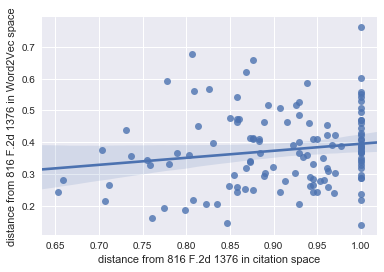

In [22]:

for item in ['816 F.2d 1376']:
    xvals=[x for x in cite_distances[item] if x != 0]
    yvals=[y for y in word_distances[item] if y != 0]
    
    dfplot=pd.DataFrame({'distance from 816 F.2d 1376 in citation space':xvals, 
                  'distance from 816 F.2d 1376 in Word2Vec space':yvals})
    sns.regplot(dfplot['distance from 816 F.2d 1376 in citation space'],
               dfplot['distance from 816 F.2d 1376 in Word2Vec space'])
    plt.savefig('./assets/sample.png')

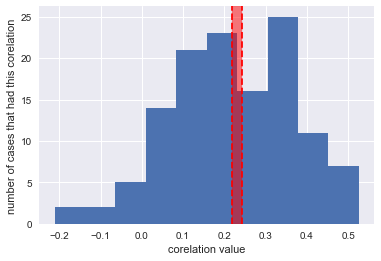

In [23]:
plt.hist(corr_list, bins=10)
plt.axvline(.218, color="red", ls='--')
plt.axvline(.243, color="red", ls='--')
plt.axvspan(.218, .243, alpha=0.5, color='red')
plt.xlabel('corelation value')
plt.ylabel('number of cases that had this corelation')
plt.savefig('./assets/avgcorr')

In [24]:
np.mean(corr_list)

0.2191299345858667

# B. Run a bootstrapping analysis to understand the variability of the average correllation.

In [25]:
len(corr_list)

126

In [26]:
def get_bootstrap_mean(corr_list):
    newlist=[]
    for i in range(len(corr_list)):
        newlist.append(np.random.choice(corr_list))
    return np.mean(newlist)

In [27]:
boot_mean_list=[]
for i in range(10000):
    boot_mean_list.append(get_bootstrap_mean(corr_list))

In [28]:
boot_means=pd.Series(boot_mean_list)

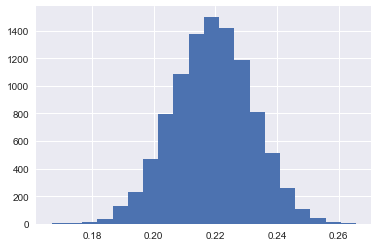

In [29]:
boot_means.hist(bins=20)

In [30]:
boot_mean_list.sort()

In [31]:
boot_mean_list[250]

0.193724724846355

In [32]:
boot_mean_list[-250]

0.243893035503264

In [33]:
boot_mean_list[5000]

0.21914947780453994

In [34]:
# We are 95% confident that the average correllation between the Word2Vec embedding
# distance and the Citation-based distance is between .218 and .243.